In [80]:
import numpy as np
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from img2vec_pytorch import Img2Vec
import torch
from PIL import Image
import csv
img2vec = Img2Vec(cuda=True)

c:\Users\Sai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:

def preprocess_image(image_path, threshold=125):
    """
    Preprocesses an image by binarizing it based on a given threshold.
    
    Args:
        image_path (str): Path to the image.
        threshold (int): Threshold for binarization (0-255). Defaults to 125.
    
    Returns:
        np.ndarray: Binarized image array.
    """
    img = mpimg.imread(image_path)
    if img.ndim == 3:  # Convert RGB to grayscale if necessary
        img = np.mean(img, axis=2)
    binary_img = (img > threshold / 255.0).astype(float)
    return binary_img

def crop_whitespace(image):
    """
    Crops the whitespace from the image by detecting the first non-white pixel 
    on all sides (top, bottom, left, right).
    
    Args:
        image (np.ndarray): Binarized image array.
    
    Returns:
        np.ndarray: Cropped image.
    """
    non_white_rows = np.any(image != 1, axis=1)
    non_white_cols = np.any(image != 1, axis=0)

    top = np.argmax(non_white_rows)
    bottom = len(non_white_rows) - np.argmax(non_white_rows[::-1]) - 1
    left = np.argmax(non_white_cols)
    right = len(non_white_cols) - np.argmax(non_white_cols[::-1]) - 1

    cropped_image = image[top:bottom+1, left:right+1]
    return cropped_image

def extract_img2vec_features(image):
    """Extract features from an image using img2vec-pytorch after converting to a PIL image."""
    # Convert the NumPy array to a PIL image
    pil_image = Image.fromarray((image * 255).astype(np.uint8))  # Convert the binary array to uint8 format (0-255)
    
    # Convert grayscale image to RGB by repeating the grayscale values across 3 channels
    pil_image = pil_image.convert("RGB")
    
    # Extract features using img2vec
    features = img2vec.get_vec(pil_image)
    
    return features

In [82]:
output_folder = 'cropped_images'
os.makedirs(output_folder, exist_ok=True)

img_number = 20

# Initialize the CSV file
csv_filename = 'i2v_scores.csv'
csv_headers = ["Image Number", "AISS", "Neural Network", "k-NN", "SVM", "Random Forest", 
               "k-NN no HOG", "SVM no HOG", "Random Forest no HOG", "CNN", "ResNet", "MobileNetV2", "AAConverter"]

# Create the CSV file if it doesn't exist
if not os.path.exists(csv_filename):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(csv_headers)

reference_image_path = f'oscii_data/images/{img_number} original.png'
cropped_reference_image = crop_whitespace(preprocess_image(reference_image_path))

# List of image file names to compare with the reference image
titles = ["AISS", "Neural Network", "k-NN", "SVM", "Random Forest", 
          "k-NN no HOG", "SVM no HOG", "Random Forest no HOG", "CNN", "ResNet", "MobileNetV2", "AAConverter"]
image_filenames = [f'examples\{img_number}\inverted\inverted_aiss.png', f'examples\{img_number}\inverted\inverted_nn.png',
      f'examples\{img_number}\inverted\inverted_knn.png', f'examples\{img_number}\inverted\inverted_svm.png', f'examples\{img_number}\inverted\inverted_rforest.png', 
      f'examples\{img_number}\inverted\inverted_knn_no_hog.png', f'examples\{img_number}\inverted\inverted_svm_no_hog.png', f'examples\{img_number}\inverted\inverted_rforest_no_hog.png', 
      f'examples\{img_number}\inverted\inverted_cnn.png', f'examples\{img_number}\inverted\inverted_resnet.png', f'examples\{img_number}\inverted\inverted_mobile.png', 
            # f'oscii_data\images\\0{j}\inverted original.png', 'examples\{j}\\aaconverter.png'
      ] 

<string>:23: SyntaxWarning: invalid escape sequence '\{'
<string>:23: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<string>:26: SyntaxWarning: invalid escape sequence '\{'
<string>:26: SyntaxWarning: invalid escape sequence '\{'
<string>:26: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\i'
<>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\i'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\i'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWar

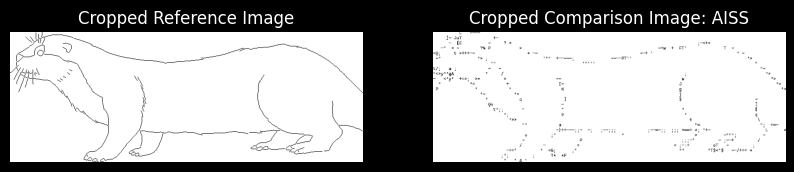

Cosine Similarity between reference image and AISS: 66.25


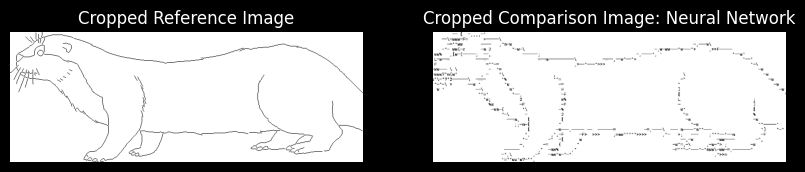

Cosine Similarity between reference image and Neural Network: 66.49


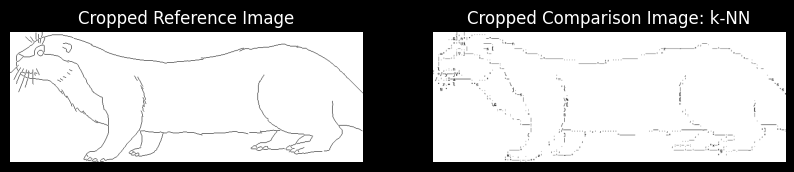

Cosine Similarity between reference image and k-NN: 73.39


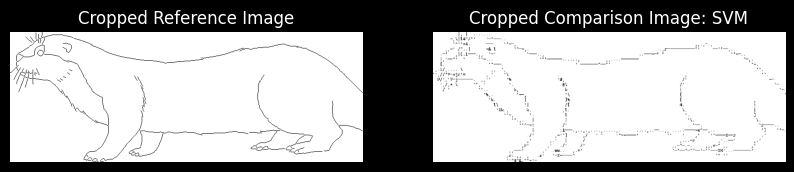

Cosine Similarity between reference image and SVM: 75.52


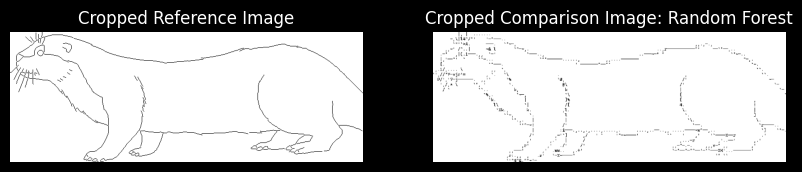

Cosine Similarity between reference image and Random Forest: 75.52


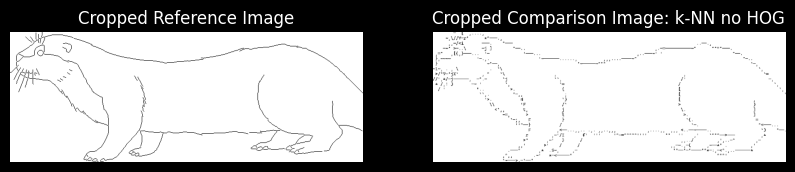

Cosine Similarity between reference image and k-NN no HOG: 75.00


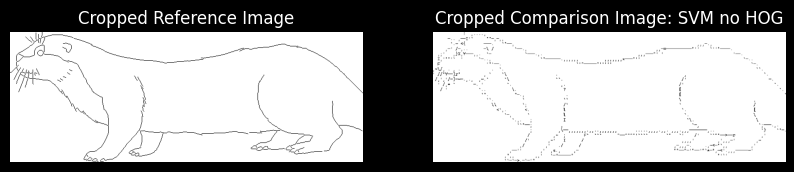

Cosine Similarity between reference image and SVM no HOG: 75.53


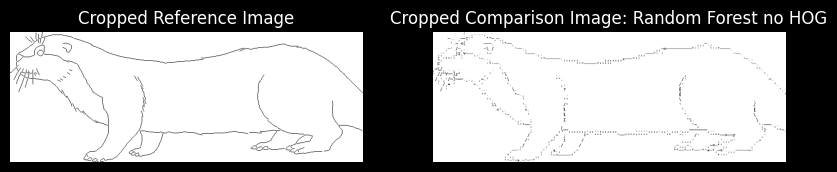

Cosine Similarity between reference image and Random Forest no HOG: 75.53


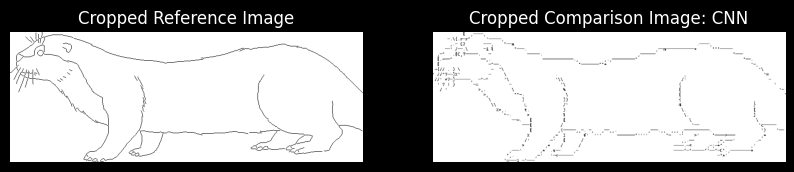

Cosine Similarity between reference image and CNN: 71.01


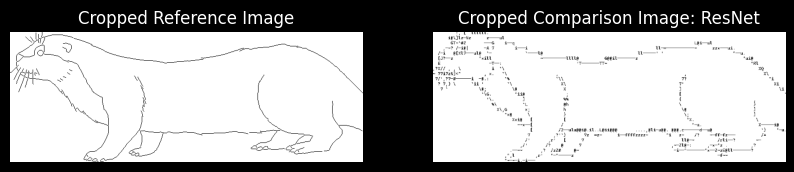

Cosine Similarity between reference image and ResNet: 69.07


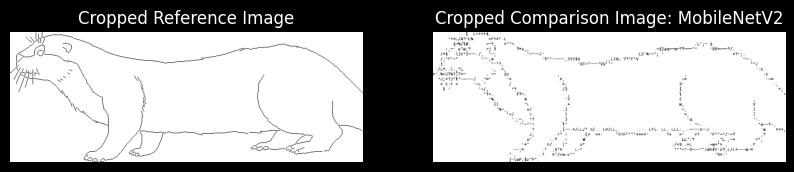

Cosine Similarity between reference image and MobileNetV2: 65.48
SSIM scores saved to i2v_scores.csv


In [83]:
# Set up the matplotlib parameters to display images with black background and white text
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
i2v_scores = [img_number]

# Loop through each image and compare using Img2Vec features
i = 0
for filename in image_filenames:
    comparison_image = preprocess_image(filename)
    cropped_comparison_image = crop_whitespace(comparison_image)

    # Ensure both cropped images have the same dimensions
    if cropped_reference_image.shape != cropped_comparison_image.shape:
        cropped_comparison_image = cv2.resize(cropped_comparison_image, (cropped_reference_image.shape[1], cropped_reference_image.shape[0]))

    # Extract features from both images using Img2Vec
    reference_features = extract_img2vec_features(cropped_reference_image)
    comparison_features = extract_img2vec_features(cropped_comparison_image)

    # Compute cosine similarity between the feature vectors
    similarity_score = cosine_similarity([reference_features], [comparison_features])[0][0]

    i2v_scores.append(similarity_score)
    # Show the images
    plt.figure(figsize=(10, 5))
    plt.gcf().patch.set_facecolor('black')
    plt.subplot(1, 2, 1)
    plt.title(f'Cropped Reference Image')
    plt.imshow(cropped_reference_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Cropped Comparison Image: {titles[i]}')
    plt.imshow(cropped_comparison_image, cmap='gray')
    plt.axis('off')

    plt.show()

    # Print the similarity score
    print(f"Cosine Similarity between reference image and {titles[i]}: {similarity_score*100:.2f}")
    
    i += 1

with open(csv_filename, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(i2v_scores)

print(f"SSIM scores saved to {csv_filename}")